In [ ]:

import random
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    T5TokenizerFast,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from transformers import T5TokenizerFast, T5ForConditionalGeneration
import evaluate
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# --------------------------------------------------
# CONFIG
# --------------------------------------------------
csv_path = "data/t15_pretrained_rnn_baseline/phoneme_text_training_data_final.csv"
MAX_SAMPLES = None        # set None for full dataset
BOUNDARY_TOKEN = "<WB>"

# --------------------------------------------------
# WER Calculation Function (similar to reference code)
# --------------------------------------------------
def calculate_aggregate_error_rate(references, hypotheses):
    def levenshtein_distance(ref, hyp):
        ref_len = len(ref)
        hyp_len = len(hyp)
        
        # Create distance matrix
        d = np.zeros((ref_len + 1, hyp_len + 1), dtype=int)
        
        # Initialize first row and column
        for i in range(ref_len + 1):
            d[i][0] = i
        for j in range(hyp_len + 1):
            d[0][j] = j
        
        # Calculate distances
        for i in range(1, ref_len + 1):
            for j in range(1, hyp_len + 1):
                if ref[i-1] == hyp[j-1]:
                    cost = 0
                else:
                    cost = 1
                
                d[i][j] = min(
                    d[i-1][j] + 1,      # deletion
                    d[i][j-1] + 1,      # insertion
                    d[i-1][j-1] + cost  # substitution
                )
        
        return d[ref_len][hyp_len]
    
    total_distance = 0
    total_ref_words = 0
    
    for ref, hyp in zip(references, hypotheses):
        ref_words = ref.split()
        hyp_words = hyp.split()
        
        distance = levenshtein_distance(ref_words, hyp_words)
        total_distance += distance
        total_ref_words += len(ref_words)
    
    if total_ref_words == 0:
        return 0.0
    
    wer = total_distance / total_ref_words
    return wer

# --------------------------------------------------
# 1. Load and prepare dataset
# --------------------------------------------------
df = pd.read_csv(csv_path, usecols=["phoneme_sequence", "sentence"])

# Ensure proper columns
if not {"phoneme_sequence", "sentence"}.issubset(df.columns):
    raise ValueError(f"Expected columns: 'phoneme_sequence' and 'sentence', found {df.columns.tolist()}")

# Drop missing and trim
df = df.dropna(subset=["phoneme_sequence", "sentence"])
df["phoneme_sequence"] = df["phoneme_sequence"].astype(str).str.strip()
df["sentence"] = df["sentence"].astype(str).str.strip()

# Normalize and replace "|" with <WB>
df["phoneme_sequence"] = (
    df["phoneme_sequence"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s*\|\s*", f" {BOUNDARY_TOKEN} ", regex=True)
)

# Limit samples (optional)
if MAX_SAMPLES is not None and MAX_SAMPLES < len(df):
    df = df.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)
    print(f"Using subset of {MAX_SAMPLES} samples for quick testing")

# Shuffle and split: 80% train, 10% val, 10% test
# Use FIXED seed for reproducibility
random.seed(1)
text_pairs = list(df.itertuples(index=False, name=None))
random.shuffle(text_pairs)

total_size = len(text_pairs)
train_size = int(0.9 * total_size)
val_size = int(0.05 * total_size)
# test_size is the remainder

train_pairs = text_pairs[:train_size]
val_pairs = text_pairs[train_size:train_size + val_size]
test_pairs = text_pairs[train_size + val_size:]

train_dataset = Dataset.from_dict({
    "phoneme_sequence": [p[0] for p in train_pairs],
    "sentence": [p[1] for p in train_pairs],
})
val_dataset = Dataset.from_dict({
    "phoneme_sequence": [p[0] for p in val_pairs],
    "sentence": [p[1] for p in val_pairs],
})
test_dataset = Dataset.from_dict({
    "phoneme_sequence": [p[0] for p in test_pairs],
    "sentence": [p[1] for p in test_pairs],
})

print(f"Loaded {len(text_pairs)} pairs:")
print(f"  Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"  Val:   {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"  Test:  {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# --------------------------------------------------
# 2. Build tokenizer (pretrained + extended phoneme vocab)
# --------------------------------------------------
LOGIT_TO_PHONEME = [
    'BLANK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M',
    'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW',
    'V', 'W', 'Y', 'Z', 'ZH', BOUNDARY_TOKEN
]

phoneme_vocab = set()
for s in train_dataset["phoneme_sequence"]:
    phoneme_vocab.update(s.split())

phoneme_vocab.update(LOGIT_TO_PHONEME)

# Load pretrained tokenizer and add new phoneme tokens
tokenizer = T5TokenizerFast.from_pretrained("t5-small")
tokenizer.add_tokens(sorted(list(phoneme_vocab)))
print(f"Tokenizer vocab size: {len(tokenizer)}")

# --------------------------------------------------
# 3. Load pretrained T5-small and expand embedding layer
# --------------------------------------------------
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.resize_token_embeddings(len(tokenizer))
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# --------------------------------------------------
# 4. Tokenize datasets
# --------------------------------------------------
MAX_LEN = 128
PREFIX = (
    "You are a phoneme-to-word model. "
    "Each '<WB>' token marks the start of a new word. "
    "Output text must have the same number of words as <WB> tokens."
)

def preprocess(examples):
    inputs = [PREFIX + s for s in examples["phoneme_sequence"]]
    model_inputs = tokenizer(
        inputs, max_length=MAX_LEN, padding="max_length", truncation=True
    )
    labels = tokenizer(
        examples["sentence"], max_length=MAX_LEN, padding="max_length", truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_enc = train_dataset.map(preprocess, batched=True, remove_columns=train_dataset.column_names)
val_enc = val_dataset.map(preprocess, batched=True, remove_columns=val_dataset.column_names)

Loaded 9498 pairs:
  Train: 8548 (90.0%)
  Val:   474 (5.0%)
  Test:  476 (5.0%)
Tokenizer vocab size: 32111
Model parameters: 60,497,920


Map:   0%|          | 0/8548 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

# Try 1 - T5 Base

In [ ]:
# --------------------------------------------------
# 5. Training setup
# --------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="models/t15_version_1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
)

# --------------------------------------------------
# 6. Train
# --------------------------------------------------
trainer.train()
trainer.save_model("models/t15_version_1")

# --------------------------------------------------
# 7. BLEU and WER evaluation
# --------------------------------------------------
bleu = evaluate.load("bleu")

def generate_output(model, tokenizer, inputs, max_length=64):
    model.eval()
    all_outputs = []
    for i in range(0, len(inputs), 8):
        batch = inputs[i:i+8]
        enc = tokenizer([PREFIX + s for s in batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN).to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_length=max_length,
                num_beams=12,
                early_stopping=True,
            )
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    return all_outputs

preds = generate_output(model, tokenizer, val_dataset["phoneme_sequence"])
refs = [[s] for s in val_dataset["sentence"]]  # BLEU expects list of lists

# Calculate BLEU
bleu_result = bleu.compute(predictions=preds, references=refs)
print(f"\n{'='*60}")
print(f"  BLEU score: {bleu_result['bleu']:.4f}")

# Calculate WER
refs_flat = [s for s in val_dataset["sentence"]]  # WER expects flat list
wer_score = calculate_aggregate_error_rate(refs_flat, preds)
print(f"  WER score: {wer_score*100:.2f}%")
print(f"{'='*60}\n")

# --------------------------------------------------
# 8. Show a few predictions
# --------------------------------------------------
print("Sample Predictions:")
print("="*60)
for i in range(min(5, len(val_dataset))):
    print(f"\nExample {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {preds[i]}")
    
    # Calculate WER for this individual example
    individual_wer = calculate_aggregate_error_rate([val_dataset['sentence'][i]], [preds[i]])
    print(f"  WER:        {individual_wer*100:.2f}%")

print("\n" + "="*60)

/tmp/ipykernel_1035087/781976754.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.084400,0.071028
2,0.073800,0.063844
3,0.080900,0.058516
4,0.069300,0.052883
5,0.063900,0.049091
6,0.055500,0.046267
7,0.056900,0.044005
8,0.048400,0.042534
9,0.048400,0.040803
10,0.044100,0.039621



  BLEU score: 0.7416
  WER score: 15.56%

Sample Predictions:

Example 1:
  Phonemes:   HH IY <WB> D IH D AH N T <WB> K AE R IY <WB> EH N IY <WB> T AY Z <WB> AO R <WB> EH N IY TH IH NG <WB> 
  Reference:  he didn't carry any ties or anything.
  Prediction: he didn't catch any time or anything.
  WER:        28.57%

Example 2:
  Phonemes:   L IH T AH L <WB> F IY L D <WB> T R IH P S <WB> AO R <WB> S AH M TH IH NG <WB> 
  Reference:  little field trips or something.
  Prediction: little fun tricks or something.
  WER:        40.00%

Example 3:
  Phonemes:   Y UW <WB> AO L S OW <WB> M AE N AH JH <WB> T UW <WB> M EY K <WB> DH EH M <WB> 
  Reference:  you also manage to make them.
  Prediction: you also mean to make them.
  WER:        16.67%

Example 4:
  Phonemes:   DH AH <WB> G R AE S R UW T S <WB> W ER <WB> W AE K T <WB> F AO R <WB> V OY S IH NG <WB> AW T <WB> 
  Reference:  the grassroots were whacked for voicing out.
  Prediction: the grasses were thrown for walking out.
  WER:       

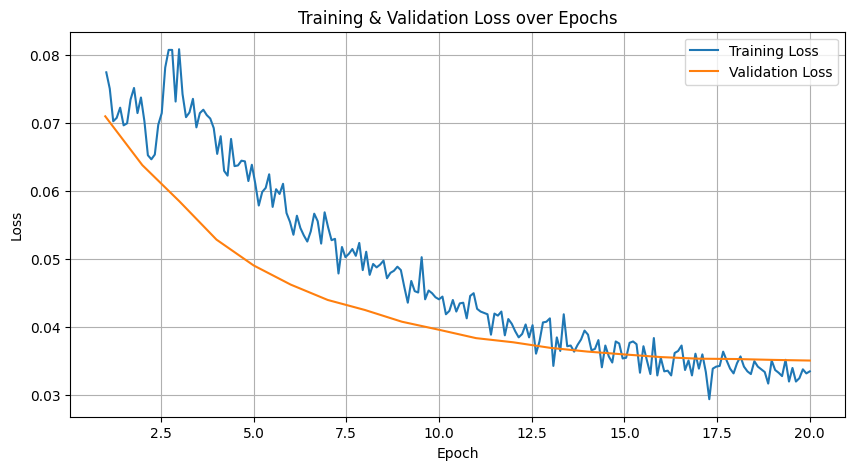

In [15]:
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_loss = logs[
    logs["loss"].notnull()
    & logs["epoch"].notnull()
    & (logs["epoch"] > 1) # Remove epoch 0
    & logs["learning_rate"].notnull()
][["epoch", "loss"]]

# Validation rows
val_loss = logs[
    logs["eval_loss"].notnull()
][["epoch", "eval_loss"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


# Try 2 - Lower Learning rate

In [ ]:
# --------------------------------------------------
# 5. Training setup
# --------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_version_2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
)

# --------------------------------------------------
# 6. Train
# --------------------------------------------------
trainer.train()
trainer.save_model("models/t5_version_2")

# --------------------------------------------------
# 7. BLEU and WER evaluation
# --------------------------------------------------
bleu = evaluate.load("bleu")

def generate_output(model, tokenizer, inputs, max_length=64):
    model.eval()
    all_outputs = []
    for i in range(0, len(inputs), 8):
        batch = inputs[i:i+8]
        enc = tokenizer([PREFIX + s for s in batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN).to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_length=max_length,
                num_beams=12,
                early_stopping=True,
            )
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    return all_outputs

preds = generate_output(model, tokenizer, val_dataset["phoneme_sequence"])
refs = [[s] for s in val_dataset["sentence"]]  # BLEU expects list of lists

# Calculate BLEU
bleu_result = bleu.compute(predictions=preds, references=refs)
print(f"\n{'='*60}")
print(f"  BLEU score: {bleu_result['bleu']:.4f}")

# Calculate WER
refs_flat = [s for s in val_dataset["sentence"]]  # WER expects flat list
wer_score = calculate_aggregate_error_rate(refs_flat, preds)
print(f"  WER score: {wer_score*100:.2f}%")
print(f"{'='*60}\n")

# --------------------------------------------------
# 8. Show a few predictions
# --------------------------------------------------
print("Sample Predictions:")
print("="*60)
for i in range(min(5, len(val_dataset))):
    print(f"\nExample {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {preds[i]}")
    
    # Calculate WER for this individual example
    individual_wer = calculate_aggregate_error_rate([val_dataset['sentence'][i]], [preds[i]])
    print(f"  WER:        {individual_wer*100:.2f}%")

print("\n" + "="*60)

/tmp/ipykernel_1035087/953694796.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.011200,0.032464
2,0.011400,0.032375
3,0.011700,0.032321
4,0.011200,0.031964
5,0.009600,0.032143
6,0.009200,0.032233
7,0.010000,0.032141
8,0.008600,0.031967
9,0.009200,0.032161
10,0.008500,0.032269



  BLEU score: 0.8032
  WER score: 11.68%

Sample Predictions:

Example 1:
  Phonemes:   HH IY <WB> D IH D AH N T <WB> K AE R IY <WB> EH N IY <WB> T AY Z <WB> AO R <WB> EH N IY TH IH NG <WB> 
  Reference:  he didn't carry any ties or anything.
  Prediction: he didn't carry any tricks or anything.
  WER:        14.29%

Example 2:
  Phonemes:   L IH T AH L <WB> F IY L D <WB> T R IH P S <WB> AO R <WB> S AH M TH IH NG <WB> 
  Reference:  little field trips or something.
  Prediction: little field trips or something.
  WER:        0.00%

Example 3:
  Phonemes:   Y UW <WB> AO L S OW <WB> M AE N AH JH <WB> T UW <WB> M EY K <WB> DH EH M <WB> 
  Reference:  you also manage to make them.
  Prediction: you also donate to make them.
  WER:        16.67%

Example 4:
  Phonemes:   DH AH <WB> G R AE S R UW T S <WB> W ER <WB> W AE K T <WB> F AO R <WB> V OY S IH NG <WB> AW T <WB> 
  Reference:  the grassroots were whacked for voicing out.
  Prediction: the grasses were thrown for'vetting out'
  WER:   

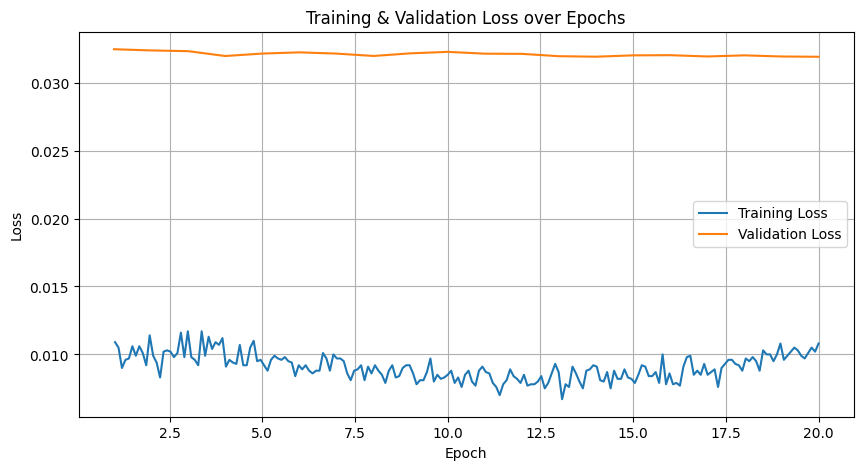

In [20]:
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_loss = logs[
    logs["loss"].notnull()
    & logs["epoch"].notnull()
    & (logs["epoch"] > 1) # Remove epoch 0
    & logs["learning_rate"].notnull()
][["epoch", "loss"]]

# Validation rows
val_loss = logs[
    logs["eval_loss"].notnull()
][["epoch", "eval_loss"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


# T5 Try 3 - T5 Finetuning

### TRAINING ARGS
- Increase Epochs to 30
- Change Learning rate to 5e-5

In [ ]:
# --------------------------------------------------
# 5. Training setup
# --------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_version_3",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
)

# --------------------------------------------------
# 6. Train
# --------------------------------------------------
trainer.train()
trainer.save_model("models/t5_version_3")

# --------------------------------------------------
# 7. BLEU and WER evaluation
# --------------------------------------------------
bleu = evaluate.load("bleu")

def generate_output(model, tokenizer, inputs, max_length=64):
    model.eval()
    all_outputs = []
    for i in range(0, len(inputs), 8):
        batch = inputs[i:i+8]
        enc = tokenizer([PREFIX + s for s in batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN).to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_length=max_length,
                num_beams=12,
                early_stopping=True,
            )
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    return all_outputs

preds = generate_output(model, tokenizer, val_dataset["phoneme_sequence"])
refs = [[s] for s in val_dataset["sentence"]]  # BLEU expects list of lists

# Calculate BLEU
bleu_result = bleu.compute(predictions=preds, references=refs)
print(f"\n{'='*60}")
print(f"  BLEU score: {bleu_result['bleu']:.4f}")

# Calculate WER
refs_flat = [s for s in val_dataset["sentence"]]  # WER expects flat list
wer_score = calculate_aggregate_error_rate(refs_flat, preds)
print(f"  WER score: {wer_score*100:.2f}%")
print(f"{'='*60}\n")

# --------------------------------------------------
# 8. Show a few predictions
# --------------------------------------------------
print("Sample Predictions:")
print("="*60)
for i in range(min(5, len(val_dataset))):
    print(f"\nExample {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {preds[i]}")
    
    # Calculate WER for this individual example
    individual_wer = calculate_aggregate_error_rate([val_dataset['sentence'][i]], [preds[i]])
    print(f"  WER:        {individual_wer*100:.2f}%")

print("\n" + "="*60)

/tmp/ipykernel_1035087/4166822641.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.029000,0.035571
2,0.026800,0.034919
3,0.028600,0.035055
4,0.026200,0.034232
5,0.024400,0.033959
6,0.022100,0.033649
7,0.024200,0.033287
8,0.020300,0.033102
9,0.021800,0.033020
10,0.020200,0.032779


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



  BLEU score: 0.7946
  WER score: 12.14%

Sample Predictions:

Example 1:
  Phonemes:   HH IY <WB> D IH D AH N T <WB> K AE R IY <WB> EH N IY <WB> T AY Z <WB> AO R <WB> EH N IY TH IH NG <WB> 
  Reference:  he didn't carry any ties or anything.
  Prediction: he didn't carry any tricks or anything.
  WER:        14.29%

Example 2:
  Phonemes:   L IH T AH L <WB> F IY L D <WB> T R IH P S <WB> AO R <WB> S AH M TH IH NG <WB> 
  Reference:  little field trips or something.
  Prediction: little field trips or something.
  WER:        0.00%

Example 3:
  Phonemes:   Y UW <WB> AO L S OW <WB> M AE N AH JH <WB> T UW <WB> M EY K <WB> DH EH M <WB> 
  Reference:  you also manage to make them.
  Prediction: you also mean to make them.
  WER:        16.67%

Example 4:
  Phonemes:   DH AH <WB> G R AE S R UW T S <WB> W ER <WB> W AE K T <WB> F AO R <WB> V OY S IH NG <WB> AW T <WB> 
  Reference:  the grassroots were whacked for voicing out.
  Prediction: the grasses were thrown for living out.
  WER:      

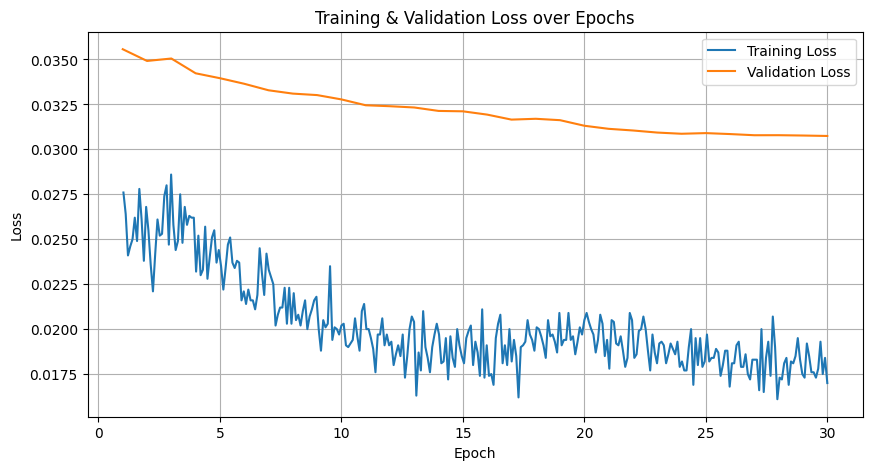

In [17]:
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_loss = logs[
    logs["loss"].notnull()
    & logs["epoch"].notnull()
    & (logs["epoch"] > 1) # Remove epoch 0
    & logs["learning_rate"].notnull()
][["epoch", "loss"]]

# Validation rows
val_loss = logs[
    logs["eval_loss"].notnull()
][["epoch", "eval_loss"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


# Try 4 - Increase epochs + add scheduler type

In [21]:
# --------------------------------------------------
# 5. Training setup
# --------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_version_4",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    warmup_steps= 500,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=30,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_version_3",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
)

# --------------------------------------------------
# 6. Train
# --------------------------------------------------
trainer.train()
trainer.save_model("models/t5_version_4")

# --------------------------------------------------
# 7. BLEU and WER evaluation
# --------------------------------------------------
bleu = evaluate.load("bleu")

def generate_output(model, tokenizer, inputs, max_length=64):
    model.eval()
    all_outputs = []
    for i in range(0, len(inputs), 8):
        batch = inputs[i:i+8]
        enc = tokenizer([PREFIX + s for s in batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN).to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_length=max_length,
                num_beams=12,
                early_stopping=True,
            )
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    return all_outputs

preds = generate_output(model, tokenizer, val_dataset["phoneme_sequence"])
refs = [[s] for s in val_dataset["sentence"]]  # BLEU expects list of lists

# Calculate BLEU
bleu_result = bleu.compute(predictions=preds, references=refs)
print(f"\n{'='*60}")
print(f"  BLEU score: {bleu_result['bleu']:.4f}")

# Calculate WER
refs_flat = [s for s in val_dataset["sentence"]]  # WER expects flat list
wer_score = calculate_aggregate_error_rate(refs_flat, preds)
print(f"  WER score: {wer_score*100:.2f}%")
print(f"{'='*60}\n")

# --------------------------------------------------
# 8. Show a few predictions
# --------------------------------------------------
print("Sample Predictions:")
print("="*60)
for i in range(min(5, len(val_dataset))):
    print(f"\nExample {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {preds[i]}")
    
    # Calculate WER for this individual example
    individual_wer = calculate_aggregate_error_rate([val_dataset['sentence'][i]], [preds[i]])
    print(f"  WER:        {individual_wer*100:.2f}%")

print("\n" + "="*60)

/tmp/ipykernel_1035087/2911134802.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.003500,0.032629
2,0.003400,0.032683
3,0.004000,0.033502
4,0.004200,0.033683
5,0.004400,0.033773
6,0.004200,0.034323
7,0.004400,0.034225
8,0.004300,0.034016
9,0.004500,0.034132
10,0.004200,0.034269



  BLEU score: 0.8119
  WER score: 10.82%

Sample Predictions:

Example 1:
  Phonemes:   HH IY <WB> D IH D AH N T <WB> K AE R IY <WB> EH N IY <WB> T AY Z <WB> AO R <WB> EH N IY TH IH NG <WB> 
  Reference:  he didn't carry any ties or anything.
  Prediction: he didn't carry any tricks or anything.
  WER:        14.29%

Example 2:
  Phonemes:   L IH T AH L <WB> F IY L D <WB> T R IH P S <WB> AO R <WB> S AH M TH IH NG <WB> 
  Reference:  little field trips or something.
  Prediction: little field trips or something.
  WER:        0.00%

Example 3:
  Phonemes:   Y UW <WB> AO L S OW <WB> M AE N AH JH <WB> T UW <WB> M EY K <WB> DH EH M <WB> 
  Reference:  you also manage to make them.
  Prediction: you also mean to make them.
  WER:        16.67%

Example 4:
  Phonemes:   DH AH <WB> G R AE S R UW T S <WB> W ER <WB> W AE K T <WB> F AO R <WB> V OY S IH NG <WB> AW T <WB> 
  Reference:  the grassroots were whacked for voicing out.
  Prediction: the grasses were whacked for voicing out.
  WER:    

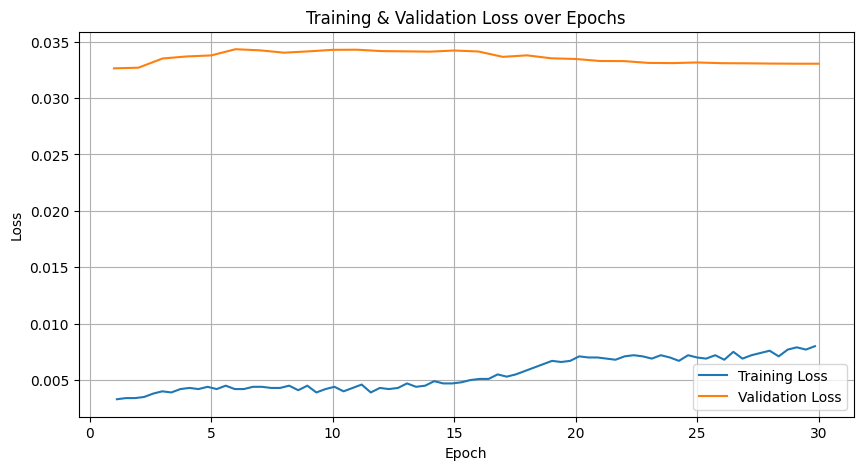

In [22]:
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_loss = logs[
    logs["loss"].notnull()
    & logs["epoch"].notnull()
    & (logs["epoch"] > 1) # Remove epoch 0
    & logs["learning_rate"].notnull()
][["epoch", "loss"]]

# Validation rows
val_loss = logs[
    logs["eval_loss"].notnull()
][["epoch", "eval_loss"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


In [26]:
# --------------------------------------------------
# 5. Training setup
# --------------------------------------------------
model.config.dropout_rate = 0.1

training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_version_5",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    warmup_steps= 500,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=30,
    predict_with_generate=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
    weight_decay=0.01,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
)

# --------------------------------------------------
# 6. Train
# --------------------------------------------------
trainer.train()
trainer.save_model("models/t5_version_5")

# --------------------------------------------------
# 7. BLEU and WER evaluation
# --------------------------------------------------
bleu = evaluate.load("bleu")

def generate_output(model, tokenizer, inputs, max_length=64):
    model.eval()
    all_outputs = []
    for i in range(0, len(inputs), 8):
        batch = inputs[i:i+8]
        enc = tokenizer([PREFIX + s for s in batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN).to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_length=max_length,
                num_beams=12,
                early_stopping=True,
            )
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    return all_outputs

preds = generate_output(model, tokenizer, val_dataset["phoneme_sequence"])
refs = [[s] for s in val_dataset["sentence"]]  # BLEU expects list of lists

# Calculate BLEU
bleu_result = bleu.compute(predictions=preds, references=refs)
print(f"\n{'='*60}")
print(f"  BLEU score: {bleu_result['bleu']:.4f}")

# Calculate WER
refs_flat = [s for s in val_dataset["sentence"]]  # WER expects flat list
wer_score = calculate_aggregate_error_rate(refs_flat, preds)
print(f"  WER score: {wer_score*100:.2f}%")
print(f"{'='*60}\n")

# --------------------------------------------------
# 8. Show a few predictions
# --------------------------------------------------
print("Sample Predictions:")
print("="*60)
for i in range(min(5, len(val_dataset))):
    print(f"\nExample {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {preds[i]}")
    
    # Calculate WER for this individual example
    individual_wer = calculate_aggregate_error_rate([val_dataset['sentence'][i]], [preds[i]])
    print(f"  WER:        {individual_wer*100:.2f}%")

print("\n" + "="*60)

/tmp/ipykernel_1035087/563486169.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.000900,0.034327
2,0.000400,0.034544
3,0.000900,0.034854
4,0.000900,0.035078
5,0.000900,0.035361
6,0.000900,0.035548
7,0.000900,0.035866
8,0.001000,0.035518
9,0.001100,0.035956
10,0.001000,0.035999



  BLEU score: 0.8192
  WER score: 10.49%

Sample Predictions:

Example 1:
  Phonemes:   HH IY <WB> D IH D AH N T <WB> K AE R IY <WB> EH N IY <WB> T AY Z <WB> AO R <WB> EH N IY TH IH NG <WB> 
  Reference:  he didn't carry any ties or anything.
  Prediction: he didn't carry any tricks or anything.
  WER:        14.29%

Example 2:
  Phonemes:   L IH T AH L <WB> F IY L D <WB> T R IH P S <WB> AO R <WB> S AH M TH IH NG <WB> 
  Reference:  little field trips or something.
  Prediction: little field trips or something.
  WER:        0.00%

Example 3:
  Phonemes:   Y UW <WB> AO L S OW <WB> M AE N AH JH <WB> T UW <WB> M EY K <WB> DH EH M <WB> 
  Reference:  you also manage to make them.
  Prediction: you also donate to make them.
  WER:        16.67%

Example 4:
  Phonemes:   DH AH <WB> G R AE S R UW T S <WB> W ER <WB> W AE K T <WB> F AO R <WB> V OY S IH NG <WB> AW T <WB> 
  Reference:  the grassroots were whacked for voicing out.
  Prediction: the grassroots were whacked for voicing out.
  WER

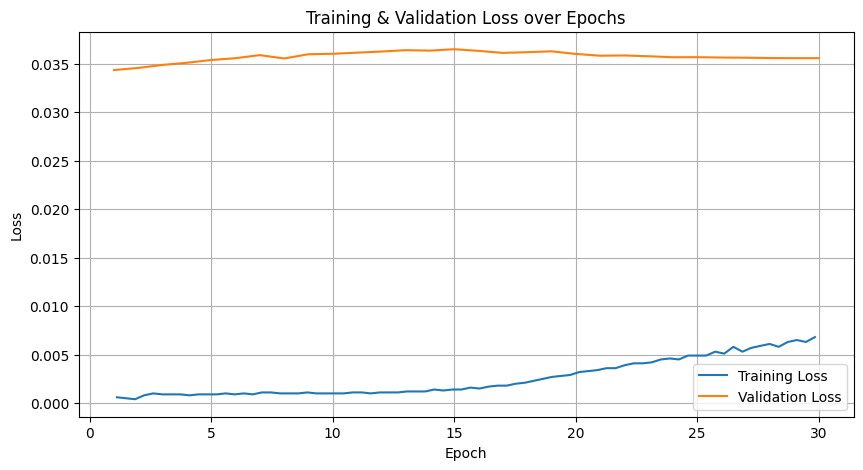

In [28]:
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_loss = logs[
    logs["loss"].notnull()
    & logs["epoch"].notnull()
    & (logs["epoch"] > 1) # Remove epoch 0
    & logs["learning_rate"].notnull()
][["epoch", "loss"]]

# Validation rows
val_loss = logs[
    logs["eval_loss"].notnull()
][["epoch", "eval_loss"]]

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


# Test different strategies 

In [ ]:
# --------------------------------------------------
# Test different model versions with Simple Beams strategy
# --------------------------------------------------

BOUNDARY_TOKEN = "<WB>"
MAX_LEN = 128
PREFIX = (
    "You are a phoneme-to-word model. "
    "Each '<WB>' token marks the start of a new word. "
    "Output text must have the same number of words as <WB> tokens."
)

# --------------------------------------------------
# WER Calculation
# --------------------------------------------------
def calculate_aggregate_error_rate(references, hypotheses):
    def levenshtein_distance(ref, hyp):
        ref_len = len(ref)
        hyp_len = len(hyp)
        d = np.zeros((ref_len + 1, hyp_len + 1), dtype=int)
        
        for i in range(ref_len + 1):
            d[i][0] = i
        for j in range(hyp_len + 1):
            d[0][j] = j
        
        for i in range(1, ref_len + 1):
            for j in range(1, hyp_len + 1):
                if ref[i-1] == hyp[j-1]:
                    cost = 0
                else:
                    cost = 1
                
                d[i][j] = min(
                    d[i-1][j] + 1,
                    d[i][j-1] + 1,
                    d[i-1][j-1] + cost
                )
        
        return d[ref_len][hyp_len]
    
    total_distance = 0
    total_ref_words = 0
    
    for ref, hyp in zip(references, hypotheses):
        ref_words = ref.split()
        hyp_words = hyp.split()
        distance = levenshtein_distance(ref_words, hyp_words)
        total_distance += distance
        total_ref_words += len(ref_words)
    
    return total_distance / total_ref_words if total_ref_words > 0 else 0.0

# --------------------------------------------------
# Simple Beams Generation Configuration
# --------------------------------------------------
GENERATION_CONFIG = {
    "max_length": 128,
    "num_beams": 8,
    "early_stopping": True,
}

# --------------------------------------------------
# Test a single model
# --------------------------------------------------
def test_model(model_path, val_dataset):
    """Test a model with Simple Beams configuration"""
    print(f"\nLoading model from: {model_path}")
    
    # Load tokenizer from model_path, not "t5-small"
    tokenizer = T5TokenizerFast.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    
    # Load model
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    bleu = evaluate.load("bleu")
    all_outputs = []
    
    # Generate predictions
    for i in range(0, len(val_dataset), 8):
        batch_phonemes = val_dataset["phoneme_sequence"][i:i+8]
        enc = tokenizer(
            [PREFIX + s for s in batch_phonemes],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LEN
        ).to(device)
        
        with torch.no_grad():
            out_ids = model.generate(**enc, **GENERATION_CONFIG)
        
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    
    # Calculate metrics
    refs = [[s] for s in val_dataset["sentence"]]
    refs_flat = list(val_dataset["sentence"])
    
    bleu_result = bleu.compute(predictions=all_outputs, references=refs)
    wer_score = calculate_aggregate_error_rate(refs_flat, all_outputs)
    
    return bleu_result['bleu'], wer_score, all_outputs

# --------------------------------------------------
# Model paths to test
# --------------------------------------------------
model_paths = [
    "models/t5_version_1",
    "models/t5_version_2",
    "models/t5_version_3",
    "models/t5_version_4",
    "models/t5_version_5",
]

print("="*70)
print("TESTING DIFFERENT MODEL VERSIONS - Simple Beams Strategy")
print("="*70)
print(f"Using val_dataset with {len(val_dataset)} samples")
print(f"Generation config: {GENERATION_CONFIG}\n")

results = []

for model_path in model_paths:
    try:
        bleu_score, wer_score, preds = test_model(model_path, val_dataset)
        
        model_name = model_path.split('/')[-1]
        results.append({
            'name': model_name,
            'path': model_path,
            'bleu': bleu_score,
            'wer': wer_score,
            'predictions': preds
        })
        
        print(f"\n{model_name}:")
        print(f"  BLEU: {bleu_score:.4f} | WER: {wer_score*100:.2f}%")
        
    except Exception as e:
        print(f"\nError loading {model_path}: {e}")

# --------------------------------------------------
# Results Summary
# --------------------------------------------------
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70 + "\n")

results_sorted = sorted(results, key=lambda x: x['bleu'], reverse=True)

print(f"{'Model':<25} {'BLEU':<12} {'WER':<10}")
print("-"*70)
for r in results_sorted:
    print(f"{r['name']:<25} {r['bleu']:.4f}       {r['wer']*100:.2f}%")

# --------------------------------------------------
# Sample Predictions for Best Model
# --------------------------------------------------
if results_sorted:
    best_result = results_sorted[0]
    print("\n" + "="*70)
    print(f"SAMPLE PREDICTIONS - BEST MODEL: {best_result['name']}")
    print("="*70 + "\n")

    for i in range(min(10, len(val_dataset))):
        print(f"Example {i+1}:")
        print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
        print(f"  Reference:  {val_dataset['sentence'][i]}")
        print(f"  Prediction: {best_result['predictions'][i]}")
        
        individual_wer = calculate_aggregate_error_rate(
            [val_dataset['sentence'][i]], 
            [best_result['predictions'][i]]
        )
        print(f"  WER: {individual_wer*100:.2f}%\n")

TESTING DIFFERENT MODEL VERSIONS - Simple Beams Strategy
Using val_dataset with 949 samples
Generation config: {'max_length': 128, 'num_beams': 8, 'early_stopping': True}


Loading model from: models/t5_version_1

t5_version_1:
  BLEU: 0.7461 | WER: 14.99%

Loading model from: models/t5_version_2

t5_version_2:
  BLEU: 0.8031 | WER: 11.59%

Loading model from: models/t5_version_3

t5_version_3:
  BLEU: 0.7971 | WER: 11.99%

Loading model from: models/t5_version_4

t5_version_4:
  BLEU: 0.8123 | WER: 10.74%

Loading model from: models/t5_version_5

t5_version_5:
  BLEU: 0.8189 | WER: 10.52%

RESULTS SUMMARY

Model                     BLEU         WER       
----------------------------------------------------------------------
t5_version_5              0.8189       10.52%
t5_version_4              0.8123       10.74%
t5_version_2              0.8031       11.59%
t5_version_3              0.7971       11.99%
t5_version_1              0.7461       14.99%

SAMPLE PREDICTIONS - BEST MODEL: 

In [40]:
# Create mapping of versions to their configurations
version_info = {
    't5_version_1': {
        'name': 'Baseline',
        'config': 'lr=1e-4, epochs=20',
        'bleu': 0.7461,
        'wer': 14.99
    },
    't5_version_2': {
        'name': 'Lower LR',
        'config': 'lr=5e-5, epochs=20',
        'bleu': 0.8031,
        'wer': 11.59
    },
    't5_version_3': {
        'name': 'Lower LR + More Epochs',
        'config': 'lr=5e-5, epochs=30',
        'bleu': 0.7971,
        'wer': 11.99
    },
    't5_version_4': {
        'name': 'Scheduler + More Epochs',
        'config': 'lr=1e-4, cosine scheduler, epochs=30',
        'bleu': 0.8123,
        'wer': 10.74
    },
    't5_version_5': {
        'name': 'Lower LR + Scheduler + Epochs + Dropout',
        'config': 'lr=5e-5, cosine scheduler, epochs=30, dropout=0.1',
        'bleu': 0.8189,
        'wer': 10.52
    }
}

# Create dataframe
df_results = pd.DataFrame.from_dict(version_info, orient='index')
df_results = df_results.sort_values('bleu', ascending=False)

# Display
print("="*80)
print("MODEL COMPARISON - SIMPLE BEAMS STRATEGY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Save to CSV
df_results.to_csv('model_comparison_results.csv', index=True)
print("\nResults saved to 'model_comparison_results.csv'")

# Show best model
best_model = df_results.iloc[0]
print(f"\nBEST MODEL: {best_model['name']}")
print(f"   Configuration: {best_model['config']}")
print(f"   BLEU: {best_model['bleu']:.4f}")
print(f"   WER: {best_model['wer']:.2f}%")

MODEL COMPARISON - SIMPLE BEAMS STRATEGY
                                   name                                            config   bleu   wer
Lower LR + Scheduler + Epochs + Dropout lr=5e-5, cosine scheduler, epochs=30, dropout=0.1 0.8189 10.52
                Scheduler + More Epochs              lr=1e-4, cosine scheduler, epochs=30 0.8123 10.74
                               Lower LR                                lr=5e-5, epochs=20 0.8031 11.59
                 Lower LR + More Epochs                                lr=5e-5, epochs=30 0.7971 11.99
                               Baseline                                lr=1e-4, epochs=20 0.7461 14.99

Results saved to 'model_comparison_results.csv'

BEST MODEL: Lower LR + Scheduler + Epochs + Dropout
   Configuration: lr=5e-5, cosine scheduler, epochs=30, dropout=0.1
   BLEU: 0.8189
   WER: 10.52%


# Test Beam Configurations

In [ ]:

# --------------------------------------------------
# Test different generation strategies on trained model
# --------------------------------------------------

import numpy as np
import evaluate
import torch
from transformers import T5ForConditionalGeneration, T5TokenizerFast

# --------------------------------------------------
# LOAD SPECIFIC MODEL TO TEST
# --------------------------------------------------
MODEL_PATH = "models/t5_version_5"

print(f"Loading model from: {MODEL_PATH}")
tokenizer = T5TokenizerFast.from_pretrained(MODEL_PATH)
model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model loaded on: {device}\n")

BOUNDARY_TOKEN = "<WB>"
MAX_LEN = 128
PREFIX = (
    "You are a phoneme-to-word model. "
    "Each '<WB>' token marks the start of a new word. "
    "Output text must have the same number of words as <WB> tokens."
)

# --------------------------------------------------
# WER Calculation
# --------------------------------------------------
def calculate_aggregate_error_rate(references, hypotheses):
    def levenshtein_distance(ref, hyp):
        ref_len = len(ref)
        hyp_len = len(hyp)
        d = np.zeros((ref_len + 1, hyp_len + 1), dtype=int)
        
        for i in range(ref_len + 1):
            d[i][0] = i
        for j in range(hyp_len + 1):
            d[0][j] = j
        
        for i in range(1, ref_len + 1):
            for j in range(1, hyp_len + 1):
                if ref[i-1] == hyp[j-1]:
                    cost = 0
                else:
                    cost = 1
                
                d[i][j] = min(
                    d[i-1][j] + 1,
                    d[i][j-1] + 1,
                    d[i-1][j-1] + cost
                )
        
        return d[ref_len][hyp_len]
    
    total_distance = 0
    total_ref_words = 0
    
    for ref, hyp in zip(references, hypotheses):
        ref_words = ref.split()
        hyp_words = hyp.split()
        distance = levenshtein_distance(ref_words, hyp_words)
        total_distance += distance
        total_ref_words += len(ref_words)
    
    return total_distance / total_ref_words if total_ref_words > 0 else 0.0

# --------------------------------------------------
# USE THE VALIDATION DATASET THAT ALREADY EXISTS
# --------------------------------------------------

print(f"Using existing val_dataset with {len(val_dataset)} samples\n")

# ... rest of your code stays the same ...

# --------------------------------------------------
# Test Different Generation Strategies
# --------------------------------------------------
bleu = evaluate.load("bleu")

def test_generation_config(name, **gen_kwargs):
    """Test a generation configuration and return metrics"""
    model.eval()
    all_outputs = []
    
    # Use val_dataset directly (already exists from training!)
    for i in range(0, len(val_dataset), 8):
        batch_phonemes = val_dataset["phoneme_sequence"][i:i+8]
        enc = tokenizer(
            [PREFIX + s for s in batch_phonemes],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LEN
        ).to(model.device)
        
        with torch.no_grad():
            out_ids = model.generate(**enc, **gen_kwargs)
        
        outs = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_outputs.extend(outs)
    
    # Calculate metrics
    refs = [[s] for s in val_dataset["sentence"]]
    refs_flat = list(val_dataset["sentence"])
    
    bleu_result = bleu.compute(predictions=all_outputs, references=refs)
    wer_score = calculate_aggregate_error_rate(refs_flat, all_outputs)
    
    return bleu_result['bleu'], wer_score, all_outputs

# --------------------------------------------------
# Configuration Tests
# --------------------------------------------------
configs = [
    {
        "name": "8 Beams",
        "params": {
            "max_length": 128,
            "num_beams": 8,
            "early_stopping": True,
        }
    },
    {
        "name": "12 Beams",
        "params": {
            "max_length": 128,
            "num_beams": 12,
            "early_stopping": True,
        }
    },
    {
        "name": "16 Beams",
        "params": {
            "max_length": 128,
            "num_beams": 16,
            "early_stopping": True,
        }
    },
    {
        "name": "Greedy",
        "params": {
            "max_length": 128,
        }
    },
    {
        "name": "Sampling (Temperature 0.7)",
        "params": {
            "max_length": 128,
            "do_sample": True,
            "temperature": 0.7,
            "top_k": 50,
            "top_p": 0.95,
        }
    },
    {
        "name": "Sampling (Temperature 0.5)",
        "params": {
            "max_length": 128,
            "do_sample": True,
            "temperature": 0.5,
            "top_k": 50,
        }
    },
    {
        "name": "Length Penalty",
        "params": {
            "max_length": 128,
            "num_beams": 12,
            "early_stopping": True,
            "length_penalty": 1.5,
        }
    },
    {
        "name": "Repetition penalty",
        "params": {
            "max_length": 128,
            "num_beams": 12,
            "no_repeat_ngram_size": 2,
            "repetition_penalty": 2.5,
            "early_stopping": True,
        }
    },
]

print("="*70)
print("TESTING DIFFERENT GENERATION STRATEGIES")
print("="*70 + "\n")

results = []

for config in configs:
    print(f"Testing: {config['name']}...")
    bleu_score, wer_score, preds = test_generation_config(
        config['name'],
        **config['params']
    )
    
    results.append({
        'name': config['name'],
        'bleu': bleu_score,
        'wer': wer_score,
        'predictions': preds
    })
    
    print(f"  BLEU: {bleu_score:.4f} | WER: {wer_score*100:.2f}%\n")

# --------------------------------------------------
# Show Results Summary
# --------------------------------------------------
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70 + "\n")

# Sort by BLEU (descending)
results_sorted = sorted(results, key=lambda x: x['bleu'], reverse=True)

print(f"{'Strategy':<35} {'BLEU':<10} {'WER':<10}")
print("-"*70)
for r in results_sorted:
    print(f"{r['name']:<35} {r['bleu']:.4f}     {r['wer']*100:.2f}%")

# --------------------------------------------------
# Show Sample Predictions for Best Strategy
# --------------------------------------------------
best_result = results_sorted[0]
print("\n" + "="*70)
print(f"SAMPLE PREDICTIONS - BEST STRATEGY: {best_result['name']}")
print("="*70 + "\n")

for i in range(min(10, len(val_dataset))):
    print(f"Example {i+1}:")
    print(f"  Phonemes:   {val_dataset['phoneme_sequence'][i]}")
    print(f"  Reference:  {val_dataset['sentence'][i]}")
    print(f"  Prediction: {best_result['predictions'][i]}")
    
    individual_wer = calculate_aggregate_error_rate(
        [val_dataset['sentence'][i]], 
        [best_result['predictions'][i]]
    )
    print(f"WER: {individual_wer*100:.2f}%\n")


Loading model from: models/t5_version_5
Tokenizer vocab size: 32111
Model loaded on: cuda

Using existing val_dataset with 949 samples

TESTING DIFFERENT GENERATION STRATEGIES

Testing: 8 Beams...
  BLEU: 0.8189 | WER: 10.52%

Testing: 12 Beams...
  BLEU: 0.8192 | WER: 10.49%

Testing: 16 Beams...
  BLEU: 0.8185 | WER: 10.56%

Testing: Greedy...
  BLEU: 0.8005 | WER: 12.68%

Testing: Sampling (Temperature 0.7)...
  BLEU: 0.7936 | WER: 13.42%

Testing: Sampling (Temperature 0.5)...
  BLEU: 0.8117 | WER: 11.09%

Testing: Length Penalty...
  BLEU: 0.8189 | WER: 10.49%

Testing: Repetition penalty...
  BLEU: 0.8011 | WER: 11.56%


RESULTS SUMMARY

Strategy                            BLEU       WER       
----------------------------------------------------------------------
12 Beams                            0.8192     10.49%
8 Beams                             0.8189     10.52%
Length Penalty                      0.8189     10.49%
16 Beams                            0.8185     10.56%
Sam

# Final Evaluation on Test Set

In [51]:
# ==================================================
# EVALUATE ON TEST SET
# ==================================================
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")

# Load your trained model
model_path = "./models/t5_version_5"
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.to(device)
model.eval()

# Generate predictions
print(f"Generating predictions for {len(test_dataset)} samples...")
predictions = []

with torch.no_grad():
    for idx in tqdm(range(len(test_dataset))):
        phonemes = test_dataset[idx]['phoneme_sequence']
        
        # Add prefix (same as training!)
        input_text = PREFIX + phonemes
        
        # Tokenize
        input_ids = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=MAX_LEN,
            truncation=True
        ).input_ids.to(device)
        
        # Generate
        outputs = model.generate(
            input_ids,
            max_length=MAX_LEN,
            num_beams=12,
            early_stopping=True,
        )
        
        # Decode
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(pred_text)

# Calculate metrics
references = [[s] for s in test_dataset['sentence']]
refs_flat = test_dataset['sentence']

bleu = evaluate.load("bleu")
bleu_result = bleu.compute(predictions=predictions, references=references)
wer_score = calculate_aggregate_error_rate(refs_flat, predictions)

# Display results
print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Size:      {len(test_dataset)} samples")
print(f"BLEU Score:     {bleu_result['bleu']:.4f} ({bleu_result['bleu']*100:.2f}%)")
print(f"WER Score:      {wer_score*100:.2f}%")
print(f"Word Accuracy:  {(1-wer_score)*100:.2f}%")
print("="*70 + "\n")

# Show examples
print("SAMPLE PREDICTIONS:\n")
for i in range(min(15, len(test_dataset))):
    print(f"Example {i+1}:")
    print(f"  Phonemes:   {test_dataset[i]['phoneme_sequence']}")
    print(f"  Reference:  {test_dataset[i]['sentence']}")
    print(f"  Prediction: {predictions[i]}")


EVALUATING ON TEST SET

Generating predictions for 476 samples...


100%|██████████| 476/476 [00:36<00:00, 12.91it/s]



TEST SET RESULTS
Test Size:      476 samples
BLEU Score:     0.9795 (97.95%)
WER Score:      1.41%
Word Accuracy:  98.59%

SAMPLE PREDICTIONS:

Example 1:
  Phonemes:   S EH V ER AH L <WB> TH IH NG Z <WB> AH B AW T <WB> DH AH <WB> K AA R <WB> N IY D <WB> F IH K S IH NG <WB> 
  Reference:  several things about the car need fixing.
  Prediction: several things about the car need fixing.
Example 2:
  Phonemes:   DH AE T S <WB> AH <WB> G UH D <WB> W EY <WB> T UW <WB> G EH T <WB> S T AA R T IH D <WB> 
  Reference:  that's a good way to get started.
  Prediction: that's a good way to get started.
Example 3:
  Phonemes:   AY <WB> D UW <WB> DH AH <WB> N UW Z P EY P ER <WB> AH N D <WB> K AA R D B AO R D <WB> AH N D <WB> P EY P ER <WB> 
  Reference:  i do the newspaper and cardboard and paper.
  Prediction: i do the newspaper and cardboard and paper.
Example 4:
  Phonemes:   AY <WB> AE M <WB> K AY N D <WB> AH V <WB> AH <WB> HH AA B IY IH S T <WB> 
  Reference:  i am kind of a hobbyist.
  Predic